In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

# Parametros
L = 40  # Tamaño del dominio (en unidades adimensionales)
N = 3000 # Numero de puntos espaciales
dx = L / N  # Paso espacial
xi = np.linspace(-L / 2, L / 2, N)  # Grid espacial en unidades adimensionales
dt = 0.0005  # Paso temporal (en unidades adimensionales)
t_max = 6.24 # Tiempo final (tiempo maximo tuneleo)
t_steps = int(t_max / dt)  # Numero de pasos temporales



# Parámetros del paquete de ondas, función de onda input
xi0 = -4 # Posición inicial partícula
kappa_0 = 4 # Momento Inicial
psi0 = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(1j * kappa_0 * xi)



# Barrera de potencial
alpha_param = 75
v_0 = 1.5 # Altura del potencial (V_0/Ec)
b = 0.6 # Grosor de la barrera (en unidades adimensionales, realmente es xi_b)
v = v_0 / (1 + np.abs(xi / b)**alpha_param)  # Forma explicita del potencial

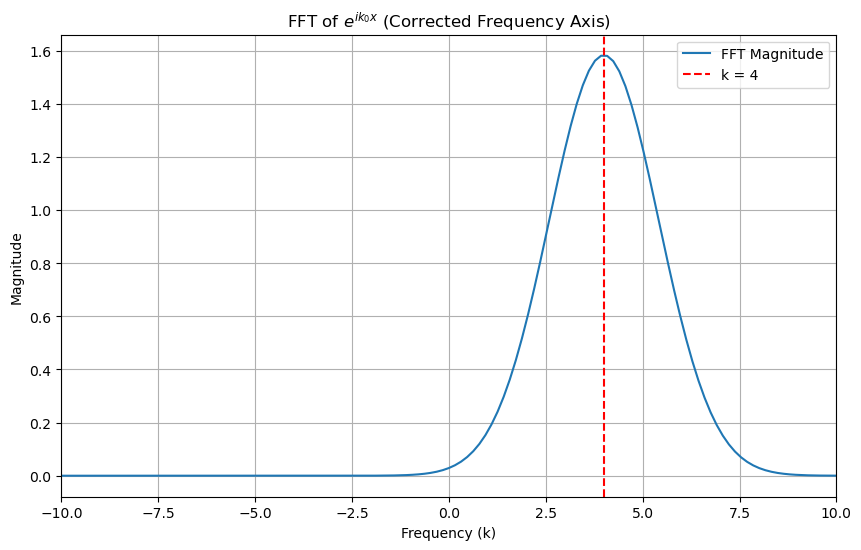

In [11]:
# Recalculate the frequencies to ensure proper scaling and alignment with FFT
frequencies = np.fft.fftshift(np.fft.fftfreq(N, d=(L/N))) * 2 * np.pi  # Scale frequencies correctly

# Recompute FFT without extra normalization and correct scaling
f_k = np.fft.fftshift(np.fft.fft(psi0)) * (L / N)

# Plot the updated results with proper frequency axis
plt.figure(figsize=(10, 6))

# Plot the magnitude of the FFT
plt.plot(frequencies, np.abs(f_k), label="FFT Magnitude")

# Plot a vertical line at k = k0 to indicate the expected delta peak
plt.axvline(kappa_0, color='r', linestyle='--', label=f'k = {kappa_0}')

plt.title("FFT of $e^{ik_0 x}$ (Corrected Frequency Axis)")
plt.xlabel("Frequency (k)")
plt.ylabel("Magnitude")
plt.xlim (-10,10)
plt.legend()
plt.grid(True)
plt.show()


<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\k'
<>:44: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\k'
<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\k'
<>:44: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_4787/922067837.py:36: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Transformada de Fourier $\psi_k$ de $\psi_0$ (Gaussiana Real)')
/tmp/ipykernel_4787/922067837.py:37: SyntaxWarning: invalid escape sequence '\k'
  plt.xlabel('Frecuencia ($\kappa$)')
/tmp/ipykernel_4787/922067837.py:44: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Densidad de Probabilidad $P(k) = |\psi_k|^2$ (Gaussiana Real)')
/tmp/ipykernel_4787/922067837.py:45: SyntaxWarning: invalid escape sequence '\k'
  plt.xlabel('Frecuencia ($\kappa$)')


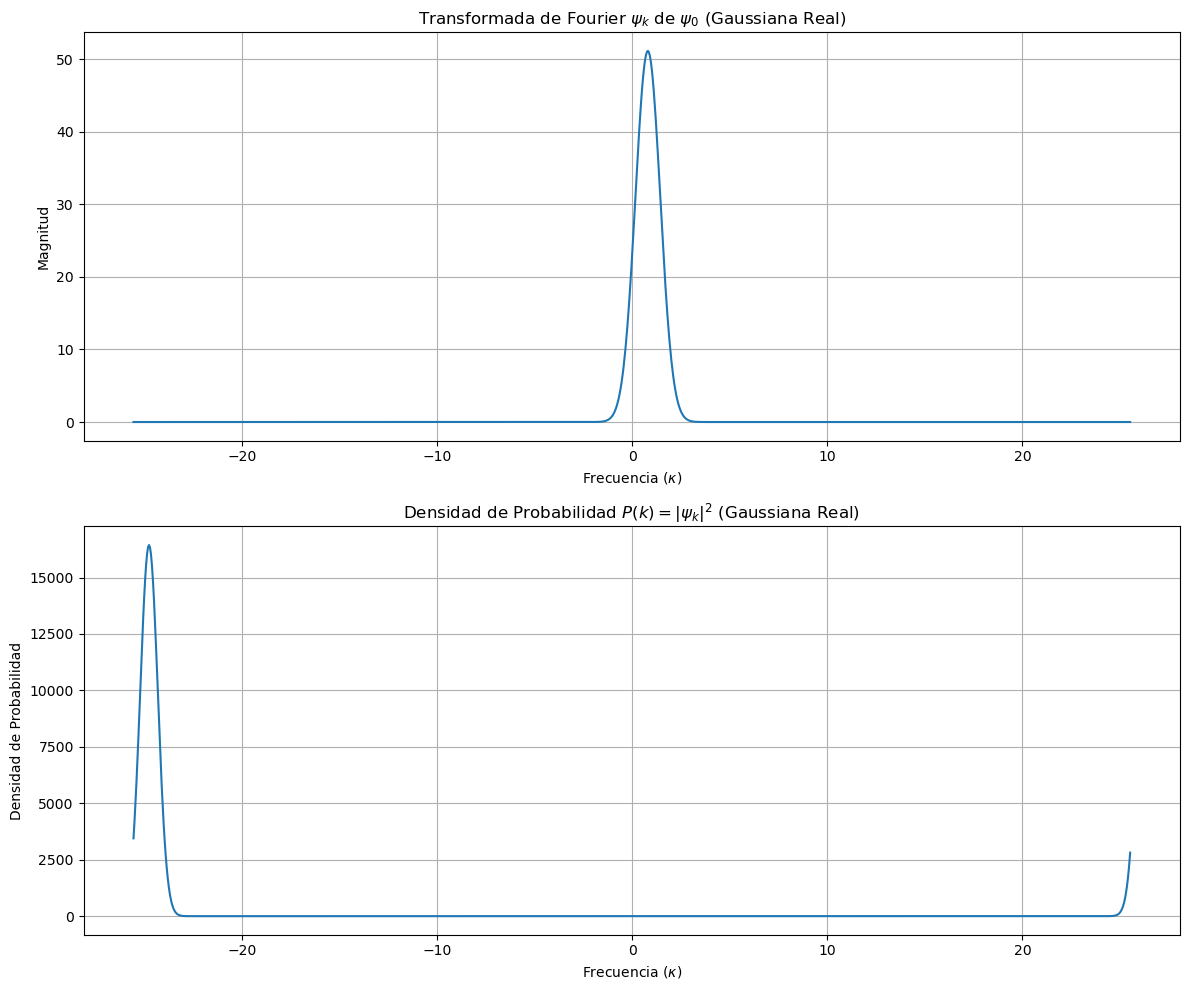

Espaciado dx: 0.019550342130987275
Frecuencias originales: [ 0.          0.04995117  0.09990234 ... -0.14985352 -0.09990234
 -0.04995117]
Frecuencias centradas: [-25.575      -25.52504883 -25.47509766 ...  25.42514648  25.47509766
  25.52504883]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Definición de los parámetros
xi0 = 0        # Centro de la gaussiana
sigma = 1/4     # Desviación estándar
A = (1 / (sigma * np.sqrt(2 * np.pi)))  # Normalización
xi = np.linspace(-10, 10, 1024)  # Rango de xi

# Calcular psi0 como una gaussiana real
psi0 = A * np.exp(-((xi - xi0)**2) / (2 * sigma**2))*np.exp(1j*5*xi)

# Calcular la transformada de Fourier para obtener psi_k
psi_k = np.fft.fft(psi0)

# Obtener el espaciado y calcular las frecuencias
dx = xi[1] - xi[0]  # Espaciado en xi
frequencies = np.fft.fftfreq(len(xi), dx)  # Frecuencias sin desplazamiento

# Centrar la transformada de Fourier
psi_k_shifted = np.fft.fftshift(psi_k)
frequencies_shifted = np.fft.fftshift(frequencies)  # Aplicar fftshift a las frecuencias

# Densidad de probabilidad en el espacio de momento
P_k = np.abs(psi_k_shifted)**2

# Aplicar fftshift a la densidad de probabilidad
P_k_shifted = np.fft.fftshift(P_k)*2*np.pi

# Visualizar psi_k y su densidad de probabilidad
plt.figure(figsize=(12, 10))

# Magnitud de psi_k
plt.subplot(2, 1, 1)
plt.plot(frequencies_shifted, np.abs(psi_k_shifted))
plt.title('Transformada de Fourier $\psi_k$ de $\psi_0$ (Gaussiana Real)')
plt.xlabel('Frecuencia ($\kappa$)')
plt.ylabel('Magnitud')
plt.grid()

# Densidad de Probabilidad en el espacio de momento
plt.subplot(2, 1, 2)
plt.plot(frequencies_shifted, P_k_shifted)
plt.title('Densidad de Probabilidad $P(k) = |\psi_k|^2$ (Gaussiana Real)')
plt.xlabel('Frecuencia ($\kappa$)')
plt.ylabel('Densidad de Probabilidad')
plt.grid()

plt.tight_layout()
plt.show()

# Imprimir información adicional para la verificación
print("Espaciado dx:", dx)
print("Frecuencias originales:", frequencies)
print("Frecuencias centradas:", frequencies_shifted)


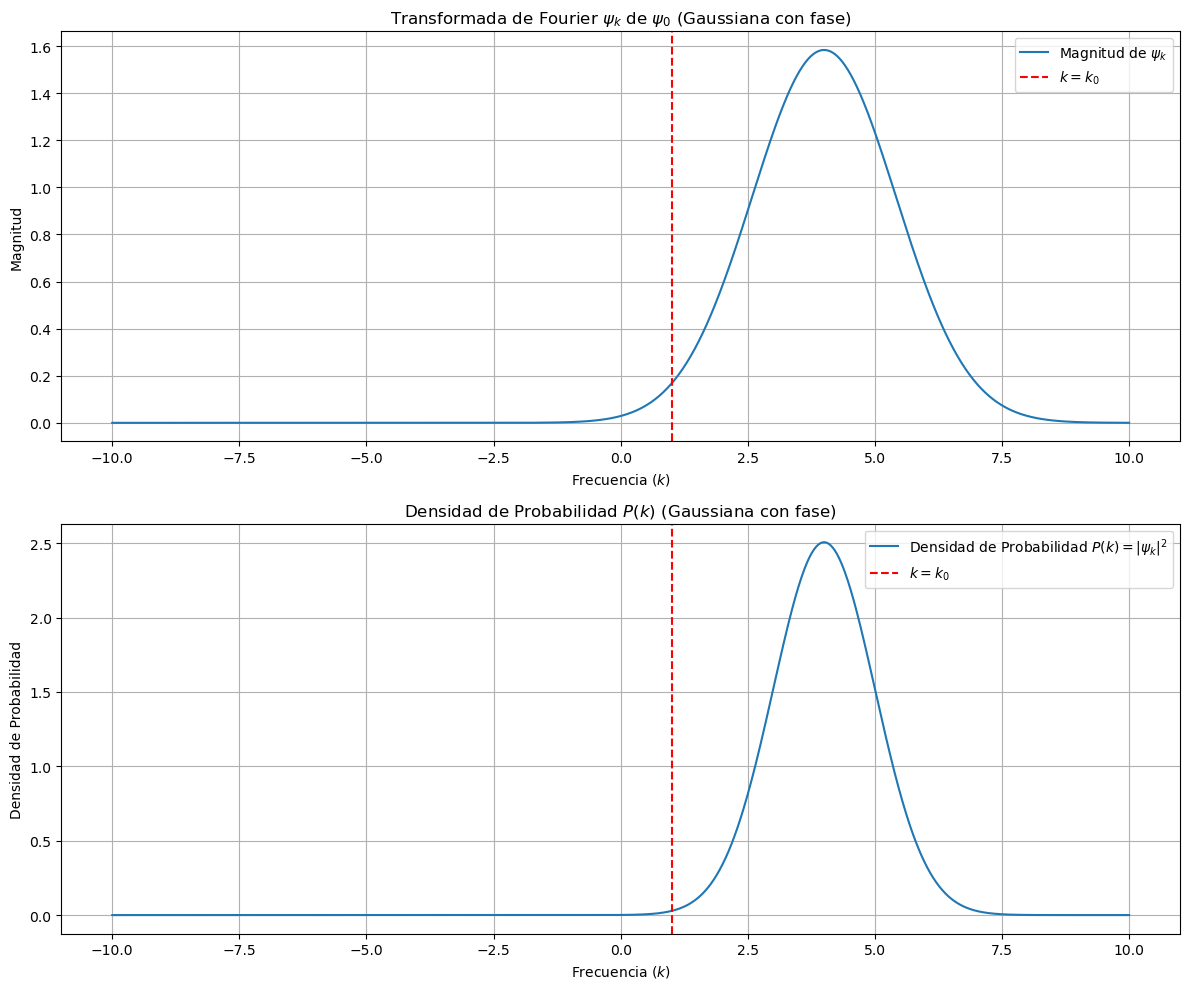

In [31]:
import numpy as np
import matplotlib.pyplot as plt


# Definir k para la transformada
k_values = np.linspace(-10, 10, 1024)


# Transformada de Fourier usando la integración numérica
def fourier_transform(k, xi, psi):
    
    # Usar el método del trapecio para la integración
    integral = np.zeros_like(k, dtype=np.complex128)
    
    for i, ki in enumerate(k):
        integral[i] = trapezoid(psi * np.exp(-1j * ki * xi), xi)

    return integral

psi = psi0.copy()

# Calcular la transformada de Fourier

psi_k = fourier_transform(k_values, xi, psi)

# Densidad de probabilidad
P_k = np.abs(psi_k)**2




# Visualizar resultados
plt.figure(figsize=(12, 10))

# Magnitud de psi_k
plt.subplot(2, 1, 1)
plt.plot(k_values, np.abs(psi_k), label=r'Magnitud de $\psi_k$')
plt.axvline(x=k0, color='r', linestyle='--', label=r'$k = k_0$')
plt.title(r'Transformada de Fourier $\psi_k$ de $\psi_0$ (Gaussiana con fase)')
plt.xlabel(r'Frecuencia ($k$)')
plt.ylabel(r'Magnitud')
plt.legend()
plt.grid()

# Densidad de Probabilidad en el espacio de momento
plt.subplot(2, 1, 2)
plt.plot(k_values, P_k, label=r'Densidad de Probabilidad $P(k) = |\psi_k|^2$')
plt.axvline(x=k0, color='r', linestyle='--', label=r'$k = k_0$')
plt.title(r'Densidad de Probabilidad $P(k)$ (Gaussiana con fase)')
plt.xlabel(r'Frecuencia ($k$)')
plt.ylabel(r'Densidad de Probabilidad')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



In [319]:
def solve_crank_nicolson (kappa_0, dx, dt, v, psi0, t):

    t_steps = int(t / dt) 
        
    # Matrices Crank-Nicolson 
    alpha = 1j * dt / (kappa_0 * dx**2)  
    beta = 1j * dt * kappa_0 / 2  

    diagonal_a = (1 + alpha + beta * v) * np.ones(N)
    off_diagonal = -(alpha / 2) * np.ones(N - 1)
    A = diags([off_diagonal, diagonal_a, off_diagonal], [-1, 0, 1], format="csr")

    diagonal_b = (1 - alpha - beta * v) * np.ones(N)
    B = diags([-off_diagonal, diagonal_b, -off_diagonal], [-1, 0, 1], format="csr")
    
    # Inicialización de la función de onda
    psi = psi0.copy()

    # Solución del problema
    for t in range(t_steps):
        psi = spsolve(A, B @ psi)

    return psi

In [320]:
def perform_momentum_measurement(psi, xi, N):
   
    dx = xi[1] - xi[0]  

    # TF para encontrar psi en espacio de k
    psi_k = np.fft.fft(psi) * dx  # dx para normalizar al dicretizar la versión continua de TF
    k_values = np.fft.fftfreq(N, d=dx) # grid del espacio de momentos

    # Producto por theta de heaviside
    positive_k_indices = k_values > 0
    psi_k_positive = psi_k[positive_k_indices]
    
    # Conserva el tamaño del espacio
    psi_k_full = np.zeros(N, dtype=complex)
    psi_k_full[positive_k_indices] = psi_k_positive

    # Devuelve al espacio de xi
    psi_measured = np.fft.ifft(psi_k_full) # TF inversa

    # Normalizar (pendiente)
    normalization_factor = np.sqrt(trapezoid(np.abs(psi_measured)**2, xi))
    psi_measured /= normalization_factor

    return psi_measured

In [321]:
def calculate_positive_kappa_probability(psi, xi):
    
    dx = xi[1] - xi[0]  

    psi_k = np.fft.fft(psi) * dx  
    k_values = np.fft.fftfreq(len(xi), d=dx)  

    positive_k_indices = k_values > 0
    psi_k_positive = psi_k[positive_k_indices]

    # Probabilidad kappa positivo
    probability_positive_kappa = np.sum(np.abs(psi_k_positive)**2) 

    # Normalizar
    normalization_factor = np.sum(np.abs(psi_k)**2)  
    if normalization_factor > 0:
        probability_positive_kappa /= normalization_factor  

    return probability_positive_kappa


In [322]:
alpha = 1j * dt / (kappa_0 * dx**2)  
beta = 1j * dt * kappa_0 / 2  

diagonal_a = (1 + alpha + beta * v) * np.ones(N)
off_diagonal = -(alpha / 2) * np.ones(N - 1)
A = diags([off_diagonal, diagonal_a, off_diagonal], [-1, 0, 1], format="csr")

diagonal_b = (1 - alpha - beta * v) * np.ones(N)
B = diags([-off_diagonal, diagonal_b, -off_diagonal], [-1, 0, 1], format="csr")

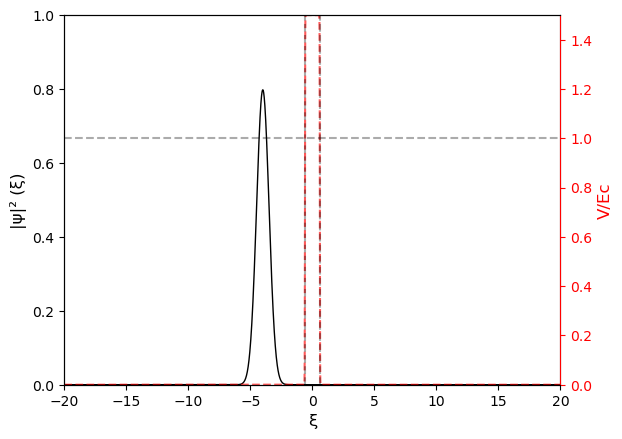

In [323]:
# Plot
fig, ax = plt.subplots()

# Plot de la densidad de probabilidad
ax.set_xlim(-L/2, L/2)
ax.set_ylim(0, 1)  
ax.set_ylabel('|ψ|² (ξ)', size=12)

# Eje para la barrera
ax2 = ax.twinx()  
ax2.set_ylim(0, 1.5)  # Límite = max barrera pot
ax2.set_ylabel('V/Ec',color='r',size = 12)
ax2.tick_params(axis='y', colors='red')  
ax2.spines['right'].set_color('red') 

ax.set_xlabel('ξ', fontsize=12)

ax2.axhline(y=1, color='black', linestyle='--',alpha = 0.33)
plt.axvline(x=b, color='k', linestyle='--', alpha=0.33)
plt.axvline(x=-b, color='k', linestyle='--', alpha=0.33)

line, = ax.plot(xi, np.abs(psi0)**2,color='k', linestyle ='-',linewidth=1) # input wavepacket

# Plot de la barrera
ax.plot(xi, v*(2/3), color='r', linestyle='--',alpha = 0.65 )

In [324]:
from matplotlib.animation import FuncAnimation

t_max = 10
t_steps = int(t_max / dt) 

# Inicialización de la función de onda
psi = psi0.copy()

num_frames = 400  
steps_per_frame = t_steps // num_frames 

# Función para actualizar el gráfico en cada paso de tiempo
def update(frame):
    global psi
    for _ in range(steps_per_frame):  # Evoluciona la función de onda varios pasos en cada cuadro
        psi = spsolve(A, B @ psi)
    
    # Actualiza la densidad de probabilidad
    line.set_ydata(np.abs(psi)**2)  
    
    # Calcula el tiempo actual
    current_time = frame * steps_per_frame * dt
    
    # Calcula la probabilidad de que kappa sea positiva
    prob_kappa_pos = calculate_positive_kappa_probability(psi, xi)

    positive_x_indices = np.where(xi > b)
    negative_x_indices = np.where (xi < b)

    psi_ref = psi[negative_x_indices] # función de onda reflejada
    psi_trans = psi[positive_x_indices] # función de onda transmitida

    # Construye función transmitida completa
    psi_trans_full = np.zeros(N, dtype=complex)
    psi_trans_full[positive_x_indices] = psi_trans
    pt = calculate_positive_kappa_probability(psi_trans_full, xi)


    # Construye función reflejada completa
    psi_ref_full = np.zeros(N, dtype=complex)
    psi_ref_full[negative_x_indices] = psi_ref
    pr = calculate_positive_kappa_probability(psi_ref_full, xi)
    
    # Actualizar el título con la probabilidad de kappa positiva
    ax.set_title(f'kappa0 = {kappa_0}, Pt = {pt:.3f}, Pr = {pr:.3f}')
    
    return line,

# Crear la animación
ani = FuncAnimation(fig, update, frames=num_frames, blit=True)

ani.save('tuneleo_animacion.mp4', writer='ffmpeg', fps=30)


KeyboardInterrupt: 

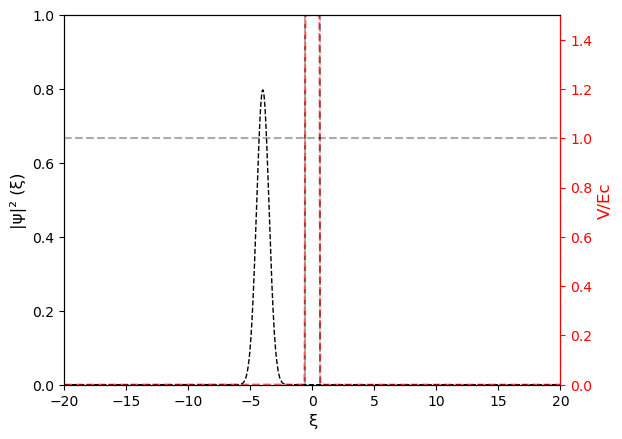

In [325]:
# Plot
fig, ax = plt.subplots()

# Plot de la densidad de probabilidad
ax.set_xlim(-L/2, L/2)
ax.set_ylim(0, 1)  
ax.set_ylabel('|ψ|² (ξ)', size=12)

# Eje para la barrera
ax2 = ax.twinx()  
ax2.set_ylim(0, 1.5)  # Límite = max barrera pot
ax2.set_ylabel('V/Ec',color='r',size = 12)
ax2.tick_params(axis='y', colors='red')  
ax2.spines['right'].set_color('red') 

ax.set_xlabel('ξ', fontsize=12)

ax2.axhline(y=1, color='black', linestyle='--',alpha = 0.33)
plt.axvline(x=b, color='k', linestyle='--', alpha=0.33)
plt.axvline(x=-b, color='k', linestyle='--', alpha=0.33)

line, = ax.plot(xi, np.abs(psi0)**2,color='k', linestyle ='--',linewidth=1) # input wavepacket

# Plot de la barrera
ax.plot(xi, v*(2/3), color='r', linestyle='--',alpha = 0.65 )



########################################################################################################################

kappa_0 = 3
t_max = 5.15

psi = psi0.copy()  # Initial wavefunction

psi = solve_crank_nicolson (kappa_0, dx, dt, v, psi0, t_max)

line, = ax.plot(xi, np.abs(psi)**2,color=plt.cm.Greys(0.35),linewidth=2) # plot de |psi|^2

positive_x_indices = np.where(xi > 0)
negative_x_indices = np.where (xi < 0)

psi_ref = psi[negative_x_indices] # función de onda reflejada
psi_trans = psi[positive_x_indices] # función de onda transmitida

# Construye función transmitida completa
psi_trans_full = np.zeros(N, dtype=complex)
psi_trans_full[positive_x_indices] = psi_trans

p = calculate_positive_kappa_probability(psi_trans_full, xi) # calcula la probabilidad de que kappa sea positiva en la parte transmitida

print( f"kappa0 = {kappa_0} |","Parte Transmitida | " ,  "P(kappa > 0) = " , p)



# Construye función reflejada completa
psi_ref_full = np.zeros(N, dtype=complex)
psi_ref_full[negative_x_indices] = psi_ref

p = calculate_positive_kappa_probability(psi_ref_full, xi) # calcula la probabilidad de que kappa sea positiva en la parte transmitida

print( f"kappa0 = {kappa_0} |","Parte Reflejada | " ,  "P(kappa > 0) = " , p)


########################################################################################################################



NameError: name 'N' is not defined